Tests: fourier descriptor based on centroid distance

In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import numpy as np
import pandas as pd 
from math import sqrt
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb
import  utils.shapeFeatures_extraction  
import csv
IMG_W = 1376
IMG_H = 1020

In [4]:
## Fetch above file 
df_cell_masks = pd.read_pickle(os.path.join(os.path.dirname(os.getcwd()), 'files', 'CRIC_data_mask_cells.csv'))
df_cell_masks

,image_id,cell_id,bethesda,image_filename,nparray_points_segm_Nucleus,nparray_points_segm_Cyto
0,1,14796,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[398, 157], [398, 156], [398, 155], [398, 155...","[[467, 232], [468, 232], [469, 232], [470, 232..."
1,1,14797,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[474, 379], [474, 378], [474, 378], [473, 378...","[[526, 418], [526, 417], [526, 416], [526, 415..."
2,1,14798,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[545, 983], [544, 983], [544, 983], [544, 982...","[[442, 870], [441, 870], [440, 870], [439, 870..."
3,1,14799,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[278, 124], [278, 124], [279, 124], [279, 124...","[[242, 44], [241, 44], [240, 44], [240, 44], [..."
4,1,14801,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[140, 217], [139, 217], [139, 217], [138, 217...","[[238, 197], [238, 196], [238, 195], [238, 194..."
...,...,...,...,...,...,...
3228,399,11539,5,dc2df7c3f88649ded343b13b9486cddf.png,"[[405, 562], [405, 563], [405, 563], [404, 563...","[[360, 542], [360, 543], [360, 543], [361, 543..."
3229,399,11540,5,dc2df7c3f88649ded343b13b9486cddf.png,"[[510, 498], [509, 498], [509, 498], [509, 499...","[[496, 439], [496, 440], [496, 440], [495, 441..."
3230,400,11535,5,9ae8a4edde40219bad6303cebc672ee4.png,"[[454, 782], [454, 783], [454, 783], [453, 783...","[[429, 737], [428, 737], [428, 737], [428, 738..."
3231,400,11536,5,9ae8a4edde40219bad6303cebc672ee4.png,"[[672, 596], [672, 597], [672, 597], [672, 597...","[[688, 492], [689, 492], [689, 492], [689, 493..."


In [15]:
img = utils.shapeFeatures_extraction.CRIC_images()
cont = 0
count_cells = np.zeros(6, dtype = int)
data = utils.shapeFeatures_extraction.create_dictionary_features()
aux = df_cell_masks.keys()[0:3]
min_curvN = np.inf
min_curvC = np.inf
for image_id, cell_id, bethesda in df_cell_masks[aux].values:   
    cell = f'{image_id:05d}_{cell_id:05d}_'
    cont+=1
    #if cont < 3230:
    #    continue        
    ## contornos                                                             
    points_N = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Nucleus'].values[0] 
    points_C = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Cyto'].values[0]
                
    # Calc regionprops metrics from Nucleos mask:
    mask_nucleo =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
    mask_nucleo[points_N[:,0],points_N[:,1]] = 1
    m_N = measure.regionprops(mask_nucleo)  
    aN = m_N[0].area
    # --- Calc curvatures and apply the ration of its circle area ratio by area
    m_curvs, zero_cross, max_points_mcurv, maximos = \
       utils.shapeFeatures_extraction.calc_curvatures(points_N[:,0],points_N[:,1], sigma=1, n_curv=8)
    if maximos.shape[0] < min_curvN:
        min_curvN = maximos.shape[0] 

    circle_area_rationN = ((1/maximos)**2*np.pi)/aN
    for i in np.arange(6):
        ch = 'Use_curv'+str(i+1)+'N' 
        print()   
        data[ch].append(circle_area_rationN[i])
    # --- Calc Fourier Coefficients for nucleus  
    x_smooth, _ = utils.shapeFeatures_extraction.gaus_smooth_signal(points_N[:,0], sigma=0.5)
    y_smooth, _ = utils.shapeFeatures_extraction.gaus_smooth_signal(points_N[:,1], sigma= 0.5)
    fdN, _ = utils.shapeFeatures_extraction.fourier_descriptors(x_smooth, y_smooth, 
                                    centroid = np.array([np.sum(x_smooth)/x_smooth.shape[0], np.sum(y_smooth)/y_smooth.shape[0]]),
                                    n_coeficients=40)
    for i in np.arange(40):
        ch = 'fdN'+str(i) 
        data[ch].append(fdN[i])
    # ---
    
    # Calc regionprops metrics from Cyto mask:
    mask_cyto =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
    mask_cyto[points_C[:,0],points_C[:,1]] = 1
    m_C = measure.regionprops(mask_cyto)
    aC = m_C[0].area
    # --- Calc curvatures and apply the ration of its circle area ratio by area
    m_curvs, zero_cross, max_points_mcurv, maximos = \
            utils.shapeFeatures_extraction.calc_curvatures(points_C[:,0],points_C[:,1], sigma=1, n_curv=8)
    circle_area_rationC = ((1/maximos)**2*np.pi)/aC
    if maximos.shape[0] < min_curvC:
        min_curvC = maximos.shape[0] 
   
    #for i in np.arange(6):
    #    ch = 'Use_curv'+str(i+1)+'C'    
    #    data[ch].append(circle_area_rationC[i])
    # --- Calc Fourier Coefficients for nucleus  
    x_smooth, _ = utils.shapeFeatures_extraction.gaus_smooth_signal(points_C[:,0], sigma=0.5)
    y_smooth, _ = utils.shapeFeatures_extraction.gaus_smooth_signal(points_C[:,1], sigma= 0.5)
    fdC, _ = utils.shapeFeatures_extraction.fourier_descriptors(x_smooth, y_smooth, 
                                    centroid = np.array([np.sum(x_smooth)/x_smooth.shape[0], np.sum(y_smooth)/y_smooth.shape[0]]),
                                    n_coeficients=40)
    #for i in np.arange(40):
    #    ch = 'fdC'+str(i) 
    #    data[ch].append(fdC[i])
    # ---
    
    
  


In [17]:
min_curvN, min_curvN

(8, 8)

In [7]:

''' 
# Função filtro gauss:
def gaus_filter(n, n_median, sig):
   # n: numero de dados
   #n_median: posição para o vr maximo da curva de Gaus (ex. n/2) 
   #sigma: desvio padrão da gausiana
   gaus_f = np.zeros(n, dtype = complex)   
   for i in np.arange(n):
      gaus_f[i] = (1./(sig*(np.sqrt(2*np.pi))))*np.exp((-1*(i- n_median)**2)/(2*sig**2))
   return gaus_f

# Calc radial distances
def calc_radial_dists(border, centroid):
    # border: an array of shape (n_points, 2)
    return cdist(border, list([centroid]), metric='euclidean') 

# Calcula FFT e frequencias  
def fft_freqs(x):
    # x: unidimensional ndarray  
    return (np.fft.fft(x), np.fft.fftfreq(x.shape[-1]))

# Calcula o espectro de energia do vetor transformado antes da gaussina
def total_energy(fft_x):
   real = np.real(fft_x)**2
   imag = np.imag(fft_x)**2
   return (real + imag)

def calc_energy(tf):
    energy = np.sqrt(total_energy(tf)) 
    return (energy, np.sum(energy))

# --- Calc Fourier Descriptor rotation, translation, scale and flip invariant
def  fourier_descriptors(x, y, centroid, n_coeficients=40):
      # 1 dimensional arrays x and y of the border 
      # fft coeficients already shifted 
      border = np.empty((x.shape[0], 2))
      border[:,0] = x
      border[:,1] = y
      # calc radial distances
      rd = calc_radial_dists(border, centroid)
      (fft, freqs) = fft_freqs(rd[:,0])
      fft = fft/fft[0]     
      energy, _ = calc_energy(fft)
      return (energy[1:n_coeficients], freqs[1:n_coeficients])
      #return fft, freqs

def gaus_smooth_signal(x, sigma):
   # x: unidimensional ndarray  
   # sigma: percentage of the number of x coords
   n = x.shape[-1]
   gaus_f = gaus_filter(n, n/2, sig = sigma/100.0*n)
   trans_gaus = np.fft.fft(gaus_f)
   trans_x=(np.fft.fft(x))
   trans_x = trans_x * trans_gaus
   itrans_x = np.fft.fftshift(np.fft.ifft(trans_x))
   return (np.real(itrans_x), np.real(gaus_f)) 

# Calcula x'(t),x''(t), y'(t), y''(t), a partir de Fourier:
def derivatives(fft_x, freqs_x):   
   dx =  freqs_x*1j
   dx2 = dx**2
   dF = np.fft.fftshift(np.fft.ifft(fft_x*dx))
   d2F= np.fft.fftshift(np.fft.ifft(fft_x*dx2))
   return ((dF), (d2F))

# Calcula Curvatures
def curvatures(dx, dx2, dy, dy2):
   n= (dx[t]*dy2[t]) - (dy[t]*dx2[t])
   d= ((dx[t]**2) + (dy[t]**2))**(3.0/2)
   return (n/d) 

import math

def rotate(origin, px, py, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def create_dictionary_features():
    list_fdN = ['fdN'+str(i) for i in np.arange(40)]
    list_fdC = ['fdC'+str(i) for i in np.arange(40)]
    list_1 = ["bethesda", "image_id", "cell_id", \
                'areaN', 'perimeterN',  \
                'major_axisN', 'minor_axisN', 'equivalent_diameterN', 'eccentricityN', \
                'circularityN', 'convexityN', 'solidityN', 'extentN', 'radial_distance_maxN', \
                'radial_distance_meanN', 'radial_distance_sdN', 'RAN', 'RIN', \
                'radial_distance_EN', 'radial_distance_kurtoseN', 'FDN', \
                'Use_curv1N', 'Use_curv2N', 'Use_curv3N', 'Use_curv4N', \
                'Use_curv5N', 'Use_curv6N', 'Use_curv7N', 'Use_curv8N', 'major_axis_angleN'] + list_fdN
                   
    list_2 = ['areaC', 'perimeterC',  \
                'major_axisC', 'minor_axisC', 'equivalent_diameterC', 'eccentricityC', \
                'circularityC', 'convexityC', 'solidityC', 'extentC', 'radial_distance_maxC', \
                'radial_distance_meanC', 'radial_distance_sdC', 'RAC', 'RIC', \
                'radial_distance_EC', 'radial_distance_kurtoseC', 'FDC', \
                'Use_curv1C', 'Use_curv2C', 'Use_curv3C', 'Use_curv4C', \
                'Use_curv5C', 'Use_curv6C', 'Use_curv7C', 'Use_curv8C', 'major_axis_angleC'] + list_fdC

    list_3 = ['area_NC', 'perimetro_NC', 'major_axis_NC', 'minor_axis_NC', 'nucleus_position', \
                'sub_major_axis_angle_NC', 'convexity_NC']  

    list_all = list_1 + list_2 + list_3
    L = []
    for i in np.arange(len(list_all)):
        L.append([])
    return dict(zip(list_all, L))      
'''    

' \n# Função filtro gauss:\ndef gaus_filter(n, n_median, sig):\n   # n: numero de dados\n   #n_median: posição para o vr maximo da curva de Gaus (ex. n/2) \n   #sigma: desvio padrão da gausiana\n   gaus_f = np.zeros(n, dtype = complex)   \n   for i in np.arange(n):\n      gaus_f[i] = (1./(sig*(np.sqrt(2*np.pi))))*np.exp((-1*(i- n_median)**2)/(2*sig**2))\n   return gaus_f\n\n# Calc radial distances\ndef calc_radial_dists(border, centroid):\n    # border: an array of shape (n_points, 2)\n    return cdist(border, list([centroid]), metric=\'euclidean\') \n\n# Calcula FFT e frequencias  \ndef fft_freqs(x):\n    # x: unidimensional ndarray  \n    return (np.fft.fft(x), np.fft.fftfreq(x.shape[-1]))\n\n# Calcula o espectro de energia do vetor transformado antes da gaussina\ndef total_energy(fft_x):\n   real = np.real(fft_x)**2\n   imag = np.imag(fft_x)**2\n   return (real + imag)\n\ndef calc_energy(tf):\n    energy = np.sqrt(total_energy(tf)) \n    return (energy, np.sum(energy))\n\n# --- Calc

In [8]:
'''d = create_dictionary_features()
     
for i in np.arange(40):
    ch = 'fdC'+str(i) 
    d[ch].append(i)

for i in np.arange(8):
   ch = 'Use_curv'+str(i+1)+'C'    
   d[ch].append(i)

d 
'''

"d = create_dictionary_features()\n     \nfor i in np.arange(40):\n    ch = 'fdC'+str(i) \n    d[ch].append(i)\n\nfor i in np.arange(8):\n   ch = 'Use_curv'+str(i+1)+'C'    \n   d[ch].append(i)\n\nd \n"

In [9]:
img = utils.shapeFeatures_extraction.CRIC_images()
cont = 0
count_cells = np.zeros(6, dtype = int)
aux = df_cell_masks.keys()[0:3]
for image_id, cell_id, bethesda in df_cell_masks[aux].values:   
    cell = f'{image_id:05d}_{cell_id:05d}_'
    cont+=1
    #if cont < 3230:
    #    continue        
    ## contornos                                                             
    points_N = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Nucleus'].values[0] 
    points_C = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Cyto'].values[0]
                
    # Calc regionprops metrics from Nucleos mask:
    mask_nucleo =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
    mask_nucleo[points_N[:,0],points_N[:,1]] = 1
    m_N = measure.regionprops(mask_nucleo)  
    # Calc regionprops metrics from Cyto mask:
    mask_cyto =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
    mask_cyto[points_C[:,0],points_C[:,1]] = 1
    m_C = measure.regionprops(mask_cyto)

    # --- Calc Fourier Coefficients for nucleus
    #FdN, freqsn =  fourier_descriptors(points_N[:,0], points_N[:,1], m_N[0].centroid, n_coeficients=40)
    x_smooth, gaus_f = gaus_smooth_signal(points_N[:,0], sigma=0.5)
    y_smooth, gaus_f = gaus_smooth_signal(points_N[:,1], sigma= 0.5)
    FdNs, freqsns =  fourier_descriptors(x_smooth, y_smooth, 
        centroid = np.array([np.sum(x_smooth)/x_smooth.shape[0], np.sum(y_smooth)/y_smooth.shape[0]]),
        n_coeficients=40)
    #---- 
     
    #fig, axis = plt.subplots(2, 4, figsize=(29,14))
    #axis[0,0].scatter(freqsn, FdN, s=5, color='r') 
    #axis[0,0].set( title = 'Nucleo', ylim=(np.min(FdN)-0.02,
    #                                       np.max(FdN)+np.max(FdN)*0.2), 
    #            yticks=(np.arange(np.min(FdN), np.max(FdN),0.01))) 
 
    #axis[0,1].plot(points_N[:,0], points_N[:,1]) #, s=5, color='r')            
    #axis[0,2].scatter(freqsns, FdNs, s=5, color='r') 
    #axis[0,2].set( title = 'Nucleo smoothed', ylim=(np.min(FdNs)-0.02,
    #              np.max(FdNs)+np.max(FdNs)*0.2), 
    #         yticks=(np.arange(np.min(FdNs), np.max(FdNs),0.01))) 
 
    #axis[0,3].plot(x_smooth, y_smooth) #, s=0.3, color='r')      
    
    #---- Calc Fourier Coefficients for cito
    #FdC, freqsc =  fourier_descriptors(points_C[:,0], points_C[:,1], m_C[0].centroid, n_coeficients=40)
    x_smooth, gaus_f = gaus_smooth_signal(points_C[:,0], sigma= 0.5)
    y_smooth, gaus_f = gaus_smooth_signal(points_C[:,1], sigma= 0.5)
    FdCs, freqscs =  fourier_descriptors(x_smooth, y_smooth, 
        centroid = np.array([np.sum(x_smooth)/x_smooth.shape[0], np.sum(y_smooth)/y_smooth.shape[0]]),
        n_coeficients=40)
    #-----
    
    #axis[1,0].scatter(freqsc, FdC, s= 5, color='r') 
    #axis[1,0].set( title = 'Citoplasma', ylim=(np.min(FdC)-0.02,
    #                                       np.max(FdC)+np.max(FdC)*0.5), 
    #            yticks=(np.arange(np.min(FdC), np.max(FdC),0.05))) 
 
    #axis[1,1].plot(points_C[:,0], points_C[:,1]) #, s=0.02, color='r')      
    #axis[1,2].scatter(freqscs, FdCs, s=5 , color='r') 
    #axis[1,2].set( title = 'Citoplasma smoothed', ylim=(np.min(FdCs) - 0.02,
    #                                       np.max(FdCs)+np.max(FdCs)*0.5), 
    #            yticks=(np.arange(np.min(FdCs), np.max(FdCs),0.05))) 
    #  axis[1,3].plot(x_smooth, y_smooth) # ,s=0.02, color='r')
    #break;

NameError: name 'gaus_smooth_signal' is not defined

In [ ]:
vx= 'MECH128X.dat'
vy= 'MECH128Y.dat'
xt = np.loadtxt(vx)
yt = np.loadtxt(vy)
x = xt[1::] 
y = yt[1::] 
xc = np.sum(x)/x.shape[-1]
yc = np.sum(y)/x.shape[-1]
t = np.arange(x.shape[-1])
rt = np.sqrt((x-xc)**2 + (y-yc)**2)  #centroid distances

array_xy = np.empty((128, 2))
array_xy[:,0] = x[:]
array_xy[:,1]= y[:]
centroid = (np.sum(x)/x.shape[-1], np.sum(y)/y.shape[-1])
freqs, fft_y = fourier_descriptors(array_xy, centroid)

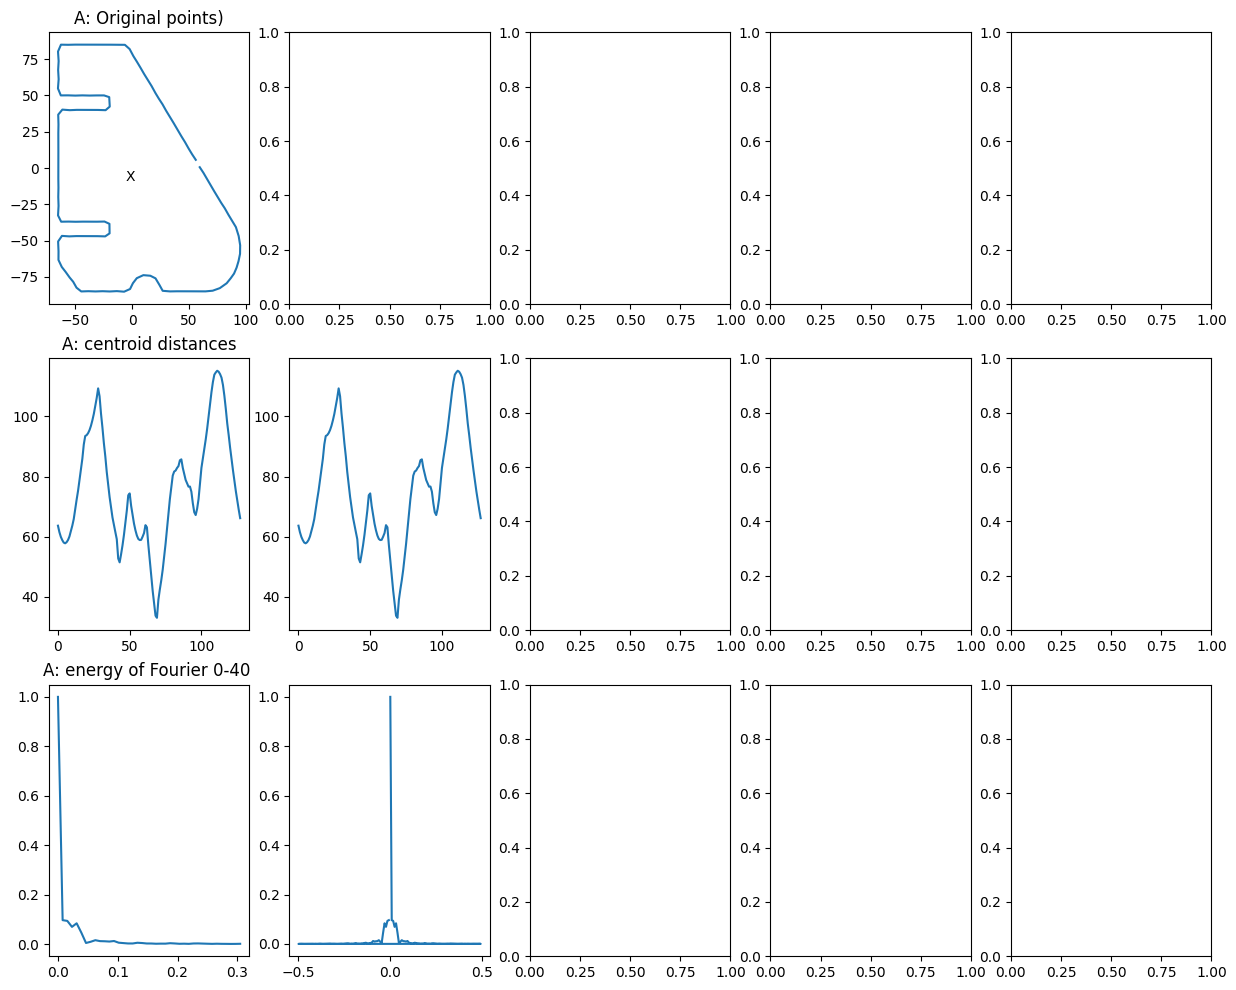

In [ ]:
fig, axis = plt.subplots(3, 5, figsize=(15,12))
axis[0,0].plot(x, y) 
axis[0,0].set_title("A: Original points)")
axis[0,0].text(centroid[0], centroid[1], 'X')
 
axis[1,0].plot(np.arange(128), rt)
axis[1,0].set_title("A: centroid distances")
axis[1,1].plot(np.arange(128),calc_radial_dists(array_xy, centroid)) 

axis[2,0].plot(freqs[0:40], (np.sqrt((np.real(fft_y))**2 + (np.imag(fft_y))**2))[0:40]) 
axis[2,0].set_title("A: energy of Fourier 0-40 ")
axis[2,1].plot(freqs, (np.sqrt((np.real(fft_y))**2 + (np.imag(fft_y))**2)))
plt.show()

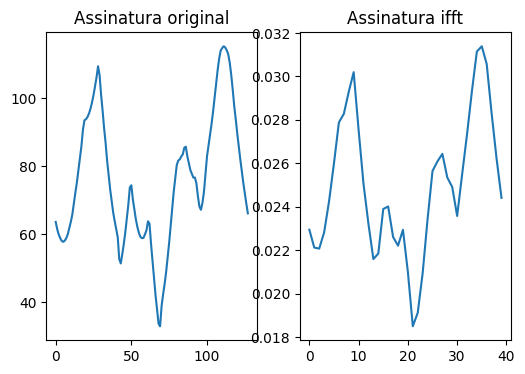

In [ ]:
fig, axis = plt.subplots(1, 4, figsize=(6,4))
axis[0].plot(np.arange(128), rt )
axis[0].set( title = 'Assinatura original') 

axis[1].plot(np.arange(128)[0:40], np.fft.ifft(fft_y[0:40]))
axis[1].set( title = 'Assinatura ifft') 

axis[2].plot((xc+rt), (yc+rt) )
axis[2].set( title = 'Assinatura original') 

axis[3].plot(np.arange(128)[0:40], np.fft.ifft(fft_y[0:40]))
axis[3].set( title = 'Assinatura ifft') 
plt.show()